# **Financial Applicactions with ML & AI**

<img style="float: right;" src="https://github.com/torreblanca99/course_financial_applications/blob/develop/docs/img/logo_bourbaki.png?raw=1" width="100"/>

## **Module III:** AI & Finance
#### Topic: Reinforcement Learning with Delta Hedging

##### Name: Julio César Avila Torreblanca

- **Objective**: apply Reinforcement Learning with Hedging
- **Contents**:
    - Notes:
        - Reinforcement Learning
    - Code:
        1. Libraries and parameters
        2. Modeling
        3. Training
        4. Evaluation
----
# Reinforcement Learning (RL)

## Introduction

Reinforcement Learning (RL) is a learning paradigm in artificial intelligence wherein an agent learns to make decisions by interacting with an environment to achieve a goal. The agent takes actions in an environment, receives feedback in the form of rewards or penalties, and adapts its strategy to maximize cumulative reward over time.

## Purpose

The main purpose of RL is to train agents that can learn optimal policies or strategies for decision-making tasks where the outcomes are uncertain and iteratively learned through trial and error.

## Key Components

1. **Agent:** The learner or decision-maker.
2. **Environment:** The external system with which the agent interacts and receives feedback.
3. **State ($S$):** A representation of the current situation of the agent.
4. **Action ($A$):** Choices available to the agent at any state.
5. **Reward ($R$):** Feedback from the environment after an action, assessing the action's effectiveness.
6. **Policy ($\pi$):** The strategy that the agent employs to determine actions based on states.

## Mathematical Representation

- **Value Function ($V(s)$)** evaluates the long-term benefit of being in a state $s$ under a policy $\pi$.
  $$
  V(s) = \mathbb{E}_\pi \left[ \sum_{t=0}^{\infty} \gamma^t R_t \mid S_0 = s \right]
  $$
  where $\gamma$ is the discount factor balancing short-term and long-term rewards.

- **Q-function ($Q(s, a)$)** evaluates the long-term benefit of taking action $a$ in state $s$ under a policy $\pi$.
  $$
  Q(s, a) = \mathbb{E}_\pi \left[ \sum_{t=0}^{\infty} \gamma^t R_t \mid S_0 = s, A_0 = a \right]
  $$

## Learning Algorithms

1. **Q-Learning:** A model-free algorithm that learns the value of actions, used to find the optimal policy:
   $$
   Q(s, a) \leftarrow Q(s, a) + \alpha \left[ R + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]
   $$
   where $\alpha$ is the learning rate.

2. **Policy Gradient Methods:** Directly parameterize the policy and optimize the parameters using gradient ascent on expected rewards.

## Advantages

- **Flexibility:** Applicable in various domains including robotics, gaming, and finance.
- **Adaptive:** Continuously learns and improves from interaction with the environment.

## Disadvantages

- **Sample Inefficiency:** Requires a large number of interactions with the environment to learn effectively.
- **Computationally Intensive:** Often requires significant computational resources.

## Comparison: Supervised Learning vs Reinforcement Learning

| Supervised Learning Component | Reinforcement Learning Component | Description                                                                            |
|-------------------------------|----------------------------------|----------------------------------------------------------------------------------------|
| **Training Data**             | **States**                       | In supervised learning, models are trained on a labeled dataset. In RL, agents learn from different states of the environment, which can be seen as "data points" that help shape the learning experience.  |
| **Labels (Ground Truth)**     | **Rewards**                      | Labels in supervised learning guide the learning process towards correct answers. Similarly, rewards in RL provide feedback to the agent, informing it about the success or failure of its actions.            |
| **Features**                  | **State Variables**              | Features are individual measurable properties or characteristics used in predicting outcomes. In RL, state variables represent the current status of the environment, akin to features in supervised learning.   |
| **Model**                     | **Policy/Agent**                 | A model in supervised learning maps features to outputs (predictions), whereas in RL, a policy dictates the agent's actions based on observed states.                                                           |
| **Loss Function**             | **Value Function/Q-Function**    | The loss function evaluates the prediction error in supervised learning. Similarly, the value function or Q-function in RL estimates the expected reward, helping evaluate the effectiveness of actions.        |
| **Optimization Algorithm**    | **Exploration/Exploitation**     | Optimization algorithms adjust model parameters to minimize loss in supervised learning. In RL, exploration and exploitation strategies are used to optimize the policy for maximal cumulative reward.            |


Reinforcement Learning combines exploration and exploitation to solve complex problems where the optimal strategy is not known a priori, making it a powerful tool in AI for dynamic decision-making tasks.

---

# 1. Libraries and parameters

In [1]:
import numpy as np
from scipy.stats import norm
import random
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm

# 2. Modeling


## 2.1 Functions

In [2]:
def brownian_sim(num_path, num_period, mu, std, init_p, dt):
    """
    Simulates asset price trajectories using a geometric Brownian motion model.

    Args:
        num_path (int): Number of simulated paths.
        num_period (int): Number of time periods for the simulation.
        mu (float): Drift term representing the expected return of the asset.
        std (float): Volatility of the asset (standard deviation of returns).
        init_p (float): Initial price of the asset.
        dt (float): Time step size (in years).

    Returns:
        np.ndarray: A 2D array of shape (num_path, num_period) containing the simulated asset prices.
                    Each row represents a single path, and each column represents a time step.
    """
    # Generate random normal variables for the Brownian motion
    z = np.random.normal(size=(num_path, num_period))

    # Initialize the price matrix with zeros
    a_price = np.zeros((num_path, num_period))
    a_price[:, 0] = init_p  # Set the initial price for all paths

    # Simulate the price paths
    for t in range(num_period - 1):
        a_price[:, t + 1] = a_price[:, t] * np.exp(
            (mu - (std ** 2) / 2) * dt + std * np.sqrt(dt) * z[:, t]
        )

    return a_price

In [3]:
def bs_parameter(volatility, time_to_maturity, spot_price, strike_price, risk_free_rate, dividend_yield):
    """
    Calculates the Black-Scholes price and delta for a European call option.

    Args:
        volatility (float): Volatility of the underlying asset (annualized standard deviation).
        time_to_maturity (float): Time to maturity in years.
        spot_price (float): Current price of the underlying asset.
        strike_price (float): Strike price of the option.
        risk_free_rate (float): Annualized risk-free interest rate.
        dividend_yield (float): Annualized dividend yield of the underlying asset.

    Returns:
        tuple:
            - bs_price (float): Black-Scholes price of the European call option.
            - bs_delta (float): Delta of the European call option.

    Raises:
        ValueError: If any input parameter is invalid (e.g., negative values for time, volatility, or prices).
    """
    # Validate inputs
    if np.any(volatility < 0) or np.any(time_to_maturity < 0) or np.any(spot_price < 0) or np.any(strike_price < 0):
        raise ValueError("Volatility, time to maturity, spot price, and strike price must be positive values.")
    if np.any(risk_free_rate < 0) or np.any(dividend_yield < 0):
        raise ValueError("Risk-free rate and dividend yield must be non-negative.")

    # Suppress warnings for log or division by zero
    np.seterr(divide='ignore', invalid='ignore')

    # Calculate d1 and d2
    d1 = (np.log(spot_price / strike_price) + 
          (risk_free_rate - dividend_yield + 0.5 * volatility ** 2) * time_to_maturity) / (volatility * np.sqrt(time_to_maturity))
    d2 = d1 - volatility * np.sqrt(time_to_maturity)

    # Calculate Black-Scholes price and delta
    bs_price = (spot_price * np.exp(-dividend_yield * time_to_maturity) * norm.cdf(d1) -
                strike_price * np.exp(-risk_free_rate * time_to_maturity) * norm.cdf(d2))
    bs_delta = np.exp(-dividend_yield * time_to_maturity) * norm.cdf(d1)

    return bs_price, bs_delta

# 3. Training

## 3.1 Initial values

In [4]:
# Define the number of trajectories generated for training and testing
TRAINING_SAMPLE = 3000000  # 3,000K
TESTING_SAMPLE = 100000  # 100K

# Characteristics of the underlying asset
# Annual return of the stock
MU = 0
# Annual volatility
VOL = 0.2
# Initial value of the asset
S = 100
# Annual return offered by a risk-free asset (Risk-Free Rate)
R = 0.05
# Annual dividends
DIVIDEND = 0
# Trading days in a year
T = 250

# Characteristics of the Call Option
# Strike price of the option
K = 100
# Time to maturity of the option
M = 10
# Number of possible positions [from 0 to 10] (state)
N_POSITION = 11
# Number of possible actions [from -5 to 5]
N_ACTION = 11

# Trading cost, measured as a percentage
TRADING_COST = 0.01

# Definition of variables for reinforcement learning
# Constant for the reward function
constant = 1
# Minimum epsilon
MIN_e = 0.05
# Initial epsilon
e = 1
# Temporal decay
DECAY = 0.999999

# Parameters to update Q
ALPHA = 0.5

# Choose the number of states for the stock price. Prices are rounded to the nearest integer.
# Prices greater than or equal to 107 are treated as the same state
# Prices less than or equal to 93 are treated as the same state
STOCK_PRICE_STATE = 15

In [5]:
# Time step per day
dt = 1 / T

# Series for the option's time to maturity
ttm = np.arange(M, -1, -1)

In [6]:
# Initialize Q with zero values for state-action pairs
q = np.zeros((M + 1, STOCK_PRICE_STATE, N_POSITION, N_ACTION))

In [7]:
# The dimensions represent: Maturity, Asset Price, Hedge State, Action to Take
q.shape

(11, 15, 11, 11)

In [8]:
# Actions to take when:
# Maturity time is 10, asset price is 100 (position 7), and holds 8 options
q[10, 7, 8]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## 3.2 EXAMPLE of behaviour

### Browian movement behaviour

In [9]:
# Just for better visualization
np.set_printoptions(suppress=True)

# Simulation of trajectories and calculation of BS parameters for the training phase
price_table = brownian_sim(TRAINING_SAMPLE, M + 1, MU, VOL, S, dt)
call_price_table, delta_table = bs_parameter(VOL, ttm / T, price_table, K, R, DIVIDEND)
print("Simulation of asset trajectories and calculation of BS parameters completed")

price_table.shape

Simulation of asset trajectories and calculation of BS parameters completed


(3000000, 11)

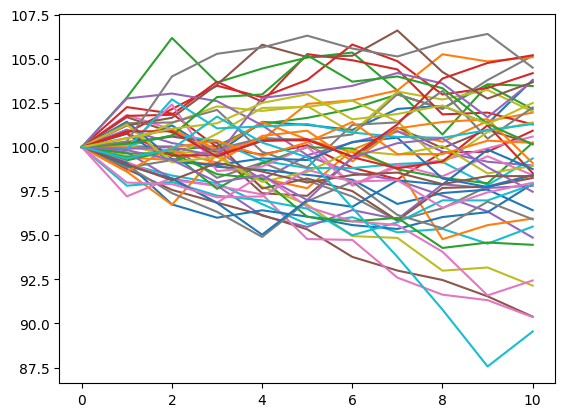

In [10]:
# Varios caminos (puede ser uno solo cambiando el rango)
for i in range(50):
  plt.plot(price_table[i,:])

In [11]:
j=4

In [12]:
price_table[j]

array([100.        , 100.98905285, 100.23235215,  99.78823912,
        98.15321532,  99.50201944,  98.55116368,  98.1188956 ,
        97.24493753,  96.34716845,  94.87011749])

In [13]:
call_price_table[j]

array([1.69596065, 2.17532189, 1.63241664, 1.29708533, 0.5493515 ,
       0.93713971, 0.4623688 , 0.24316059, 0.04722032, 0.00061452,
       0.        ])

In [14]:
delta_table[j]

array([0.52790317, 0.62769917, 0.55071934, 0.49809444, 0.29205267,
       0.44946819, 0.29714825, 0.20371053, 0.06295449, 0.00175159,
       0.        ])

### States and actions for RL

In [15]:
# Rounding asset prices and converting them to 15 different states (EASY way to calculate the state)
# [<=93,94,95,96, ... 103,104,105,106, >= 107] - > [0,1,2,3,4,....12,13,14]
price_state_table = np.round(price_table).astype(int)
price_state_table = np.where(price_state_table < 93, 93, price_state_table)
price_state_table = np.where(price_state_table > 107, 107, price_state_table)
price_state_table = price_state_table - 93

In [16]:
price_table[4]

array([100.        , 100.98905285, 100.23235215,  99.78823912,
        98.15321532,  99.50201944,  98.55116368,  98.1188956 ,
        97.24493753,  96.34716845,  94.87011749])

In [17]:
price_state_table[4]

array([7, 8, 7, 7, 5, 7, 6, 5, 4, 3, 2])

## 3.3 All training

In [18]:
print("Training in progress:")

for i in tqdm(range(len(price_table))):

    asset_price = price_table[i]
    price_state = price_state_table[i]
    bscall = call_price_table[i]
    position = 0
    position_list = np.empty(0, dtype=int)
    reward_list = np.empty(0, dtype=int)
    action_list = np.empty(0, dtype=int)
    total_reward = np.empty(0, dtype=int)

    # The agent observes the state
    # The agent makes a decision (this decision modifies the state)
    # Q is updated
    # The reward is calculated
    # The cycle repeats

    for t in range(M):
        if np.random.rand() <= e:
            # EXPLORATION
            # Note that the range of actions is between selling 5 shares and buying 5 shares
            # That's why 5 is subtracted from the chosen action here
            action = random.randrange(0, N_ACTION) - 5
        else:
            # EXPLOITATION
            # Assume that at time 0 the agent has 0 shares
            if t == 0:
                lookup_position = 0
            else:
                lookup_position = position_list[t-1]
            # If 'exploitation' is activated, find the minimum non-zero value in Q
            # A 'try' is used because the agent may reach a state not visited before, where all Q values are zero
            # If the agent reaches a state it has never been in before, a random action is taken
            try:
                action = np.where(q[t][price_state[t]][lookup_position] == np.min(q[t][price_state[t]][lookup_position][np.nonzero(q[t][price_state[t]][lookup_position])]))[0][0] - 5
            except:
                action = random.randrange(0, N_ACTION) - 5

        # Forcing the agent to have between 0 and 10 shares only
        if position + action > 10:
            action = 10 - position
            new_position = 10
        elif position + action < 0:
            action = -position
            new_position = 0
        else:
            new_position = action + position

        # Conditional to calculate transaction cost (when it is not zero). Note: When delta is sought for delta hedging, the transaction cost is 0
        # If t is one day before maturity, an extra cost is charged for selling them at the end of the period
        if t == M-1:
            transaction_cost = (asset_price[t] * abs(new_position - position) * TRADING_COST + new_position * asset_price[t+1] * TRADING_COST)
        else:
            transaction_cost = (asset_price[t] * abs(new_position - position) * TRADING_COST)

        # The reward is calculated as
        # PNL is a formulation where the hedge is calculated at each stage
        # expected hedging cost + constant * variance of total pnl from hedging.

        # When seeking delta, the reward is minimizing the variance of total P&L in the hedging case
        # The constant is taken as 1 for the case of seeking delta.
        reward = transaction_cost + constant * (transaction_cost - (asset_price[t+1] - asset_price[t]) * new_position + 10 * (bscall[t+1] - bscall[t]))**2

        position_list = np.append(position_list, new_position)
        position = new_position
        action_list = np.append(action_list, action)
        reward_list = np.append(reward_list, reward)

    position_list = np.append(position_list, 0)
    action_list = np.append(action_list, 0)
    total_reward = np.append(total_reward, sum(reward_list))

    # Convert the list of actions from -5 to 5 into 0 to 10, the table starts with index 0
    # That is: index 0 in the table means action = -5 and index 10 in the table means action = 5
    action_list = action_list + 5

    # Update Q
    for t in range(M):
        if t == 0:
            lookup_position = 0
        else:
            lookup_position = position_list[t-1]
        qnew = reward_list[t] + q[t+1][price_state[t+1]][position_list[t]][action_list[t+1]]
        q[t][price_state[t]][lookup_position][action_list[t]] = q[t][price_state[t]][lookup_position][action_list[t]] + ALPHA * (qnew - q[t][price_state[t]][lookup_position][action_list[t]])

    # Decay over time (epsilon) so that the agent becomes more prone to using EXPLOITATION
    if e > MIN_e:
        e = e * DECAY

# Save Q at the end after training
np.save('Q_RL_Hedging', q)


Training in progress:


100%|██████████| 3000000/3000000 [05:53<00:00, 8481.99it/s]


# 4. Evaluation

Taking best decision with the agent trained

## 4.1 Evaluate one decision with the agent trained

In [20]:
# Load the Q matrix for testing
q = np.load('Q_RL_Hedging.npy')

q.shape

(11, 15, 11, 11)

In [22]:
# Example of accessing the Q value for a specific state-action pair
# Maturity time = 6, asset price = 3 (position 0), action to take = 10
q[     6,    0,        10]

array([ 75.03139604, 168.52894804, 204.77740148, 332.2627256 ,
       329.77062016, 341.05752273,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ])

In [23]:
# Simulate asset price trajectories and calculate BS parameters for the testing phase
price_table = brownian_sim(TESTING_SAMPLE,M+1, MU, VOL, S, dt)
call_price_table, delta_table = bs_parameter(VOL, ttm / T, price_table, K,R, DIVIDEND)

In [24]:
delta_table

array([[0.52790317, 0.59988975, 0.60677402, ..., 0.95531685, 0.99154208,
        1.        ],
       [0.52790317, 0.4767582 , 0.45033827, ..., 0.0142417 , 0.00000051,
        0.        ],
       [0.52790317, 0.69725215, 0.48908695, ..., 0.94703881, 0.99878158,
        1.        ],
       ...,
       [0.52790317, 0.6760901 , 0.8261306 , ..., 0.42175871, 0.64427926,
        1.        ],
       [0.52790317, 0.50966152, 0.29284832, ..., 0.00104289, 0.0000627 ,
        0.        ],
       [0.52790317, 0.46435485, 0.38121722, ..., 0.01867258, 0.00091167,
        0.        ]], shape=(100000, 11))

In [25]:
# Round delta to the nearest first decimal
rounded_delta = np.round(delta_table * 100 / 10, 0).astype(int) / 10
print("Simulation of asset trajectories and calculation of BS parameters completed")

# Rounding asset prices and converting them to the 15 different states
# [<=93,94,95,96, ... 103,104,105,106, >= 107] -> [0,1,2,3,4,5,....12,13,14,15]
price_state_table = np.round(price_table).astype(int)
price_state_table = np.where(price_state_table < 93, 93, price_state_table)
price_state_table = np.where(price_state_table > 107, 107, price_state_table)
price_state_table = price_state_table - 93

Simulation of asset trajectories and calculation of BS parameters completed


## 4.2 Evaluate all simulations

In [26]:
total_rl_reward = np.empty(0, dtype=int)
total_dh_reward = np.empty(0, dtype=int)
all_shares_pnl = np.empty(shape=(TESTING_SAMPLE, len(ttm)-1))
all_call_option_pnl = np.empty(shape=(TESTING_SAMPLE, len(ttm)-1))
abs_deviation = list()

print("Test is in progress:")
for i in tqdm(range(len(price_table))):

    rl_position = 0
    dh_position = 0
    asset_price = price_table[i]
    price_state = price_state_table[i]
    bscall = call_price_table[i]
    bsdelta = rounded_delta[i]
    position_list = np.empty(0, dtype=int)
    rl_reward_list = np.empty(0, dtype=int)
    dh_reward_list = np.empty(0, dtype=int)
    action_list = np.empty(0, dtype=int)
    shares_pnl = np.empty(0, dtype=int)
    call_option_pnl = np.empty(0, dtype=int)

    for t in range(M):

        # Position to maintain if the agent applies Delta Hedging
        new_dh_position = bsdelta[t]

        # Assume that at time 0 the agent has 0 shares
        if t == 0:
            lookup_position = 0
        else:
            lookup_position = position_list[t-1]

        # Choose action by finding the minimum non-zero value in the Q table
        # Use try because the agent may reach a position not seen before.
        # If that happens, the agent does not trade shares in any way
        try:
            rl_action = np.where(q[t][price_state[t]][lookup_position]==np.min(q[t][price_state[t]][lookup_position][np.nonzero(q[t][price_state[t]][lookup_position])]))[0][0] - 5
        except:
            rl_action = 0

        # Force the agent to maintain shares between 0 and 10
        if rl_position + rl_action >10:
            rl_action = 10 - rl_position
            new_rl_position = 10
        elif rl_position + rl_action <0:
            rl_action = -rl_position
            new_rl_position = 0
        else:
            new_rl_position = rl_action + rl_position

        # Calculate P&L period by period for both cases: Delta Hedging and Reinforcement Learning Hedging
        if t == M-1:
            rl_transaction_cost = (asset_price[t]*abs(new_rl_position - rl_position)*TRADING_COST + new_rl_position*asset_price[t+1]*TRADING_COST)
            dh_transaction_cost = (asset_price[t]*abs(new_dh_position - dh_position)*TRADING_COST + new_dh_position*asset_price[t+1]*TRADING_COST)
        else:
            rl_transaction_cost = (asset_price[t]*abs(new_rl_position - rl_position)*TRADING_COST)
            dh_transaction_cost = (asset_price[t]*abs(new_dh_position - dh_position)*TRADING_COST)


        call_option_pnl = np.append(call_option_pnl,10*(bscall[t+1] - bscall[t]))
        shares_pnl = np.append(shares_pnl, (asset_price[t+1] - asset_price[t])*new_rl_position)
        rl_reward = rl_transaction_cost - (asset_price[t+1] - asset_price[t])*new_rl_position+10*(bscall[t+1] - bscall[t])
        dh_reward = dh_transaction_cost - (asset_price[t+1] - asset_price[t])*new_dh_position+10*(bscall[t+1] - bscall[t])


        position_list= np.append(position_list,new_rl_position)
        action_list = np.append(action_list,rl_action)
        rl_position = new_rl_position
        dh_position = new_dh_position
        rl_reward_list = np.append(rl_reward_list,rl_reward)
        dh_reward_list = np.append(dh_reward_list,dh_reward)

    abs_deviation = np.append(abs_deviation,sum(abs(bsdelta[:-1]-position_list))/10)
    position_list = np.append(position_list,0)
    action_list = np.append(action_list,0)
    total_rl_reward = np.append(total_rl_reward,sum(rl_reward_list))
    total_dh_reward = np.append(total_dh_reward,sum(dh_reward_list))
    all_shares_pnl[i,:] = shares_pnl
    all_call_option_pnl[i,:]  = call_option_pnl

print('\n Reinforcement Learning Hedging Statistics:')
print(' RL E(C):', np.average(total_rl_reward))
print(' RL var(C):', np.var(total_rl_reward))
print(' RL std(C):', np.std(total_rl_reward))

print('\n Delta Hedging Statistics:')
print(' Delta E(C):', np.average(total_dh_reward))
print(' Delta var(C):', np.var(total_dh_reward))
print(' Delta std(C):', np.std(total_dh_reward))

print('\n Position Difference:')
print(' Average absolute difference between DH and RLH positions:', np.average(abs_deviation))


Test is in progress:


100%|██████████| 100000/100000 [00:21<00:00, 4752.12it/s]


 Reinforcement Learning Hedging Statistics:
 RL E(C): 22.25647513030116
 RL var(C): 82.51258930986995
 RL std(C): 9.083644054555966

 Delta Hedging Statistics:
 Delta E(C): 0.9050219372074381
 Delta var(C): 474.22801975681125
 Delta std(C): 21.776777074599703

 Position Difference:
 Average absolute difference between DH and RLH positions: 4.6510993


In [27]:
q[9,7,8]

array([237.54732489, 327.15429015,  26.50427114, 231.02225056,
       289.39811672, 362.66949921, 634.69298017, 229.67839585,
         0.        ,   0.        ,   0.        ])

<Axes: >

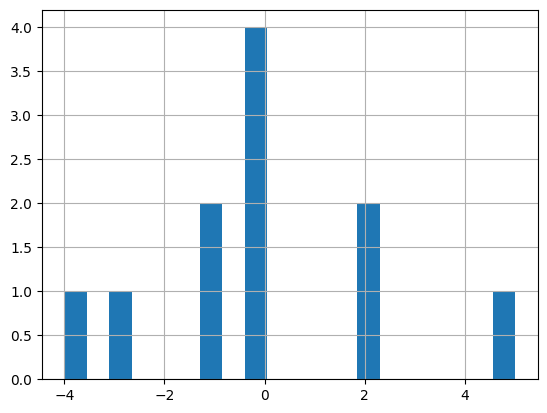

In [29]:
pd.Series(action_list).hist(bins=20)